In [17]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import ARIMA
from utilsforecast.evaluation import evaluate

import warnings
import logging
warnings.filterwarnings("ignore", category=FutureWarning)
logging.getLogger("optuna").setLevel(logging.WARNING)

In [18]:
# Definir las métricas
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def evaluate(cv_df, metrics):
    results = {}
    for metric in metrics:
        y_true = cv_df['y'].values
        y_pred = cv_df['ARIMA'].values
        results[metric.__name__] = metric(y_true, y_pred)
    return results

In [19]:
import yfinance as yf

# Descargar datos
#tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
tickers = ['BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1mo')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)


[*********************100%%**********************]  1 of 1 completed


In [20]:
horizon = 6

In [21]:
# Definir función objetivo para Optuna
def objective(trial):
    # Definir el espacio de búsqueda de hiperparámetros
    order = (trial.suggest_int('p', 0, 3), 
             trial.suggest_int('d', 0, 2), 
             trial.suggest_int('q', 0, 3))
    seasonal_order = (trial.suggest_int('P', 0, 3), 
                      trial.suggest_int('D', 0, 2), 
                      trial.suggest_int('Q', 0, 3))
    season_length = trial.suggest_int('season_length', 1, 12)

    # Instanciar el modelo ARIMA con los parámetros
    model = ARIMA(order=order, 
                  seasonal_order=seasonal_order, 
                  season_length=season_length)
    
    # Instanciar StatsForecast
    sf = StatsForecast(df=Y_df, models=[model], freq='MS', n_jobs=-1)

    # Validación cruzada
    cv_df = sf.cross_validation(df=Y_df, h=horizon, step_size=horizon, n_windows=5)
    cv_df = cv_df.reset_index()
    
    # Evaluar las predicciones
    evaluation_results = evaluate(cv_df.loc[:, cv_df.columns != 'cutoff'], metrics=[smape, mape, mse, mae, rmse])
    
    print(evaluation_results)
    
    # Obtener SMAPE para la optimización
    smape_value = evaluation_results['smape']

    return smape_value 

# Configurar y ejecutar la optimización con Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# Mostrar los mejores parámetros
best_params = study.best_params
print("Best hyperparameters:", study.best_params)
print("Best SMAPE:", study.best_value)

{'smape': 27.308151125907898, 'mape': 29.55062985420227, 'mse': 174227470.0, 'mae': 10014.069, 'rmse': 13199.525}
{'smape': 80.47354817390442, 'mape': 127.81647443771362, 'mse': 1694348500.0, 'mae': 32609.855, 'rmse': 41162.465}
{'smape': 49.731385707855225, 'mape': 44.03593838214874, 'mse': 344375420.0, 'mae': 14742.143, 'rmse': 18557.355}
{'smape': 70.31884789466858, 'mape': 527.1058559417725, 'mse': 960880800000.0, 'mae': 317393.53, 'rmse': 980245.25}
{'smape': 48.10991883277893, 'mape': 56.21870160102844, 'mse': 480510750.0, 'mae': 16282.965, 'rmse': 21920.555}
{'smape': 60.67721247673035, 'mape': 79.9325942993164, 'mse': 849311000.0, 'mae': 24264.549, 'rmse': 29142.94}
{'smape': 24.62127059698105, 'mape': 27.144429087638855, 'mse': 151753940.0, 'mae': 8640.245, 'rmse': 12318.845}
{'smape': 100.13445615768433, 'mape': 122.39106893539429, 'mse': 1966534100.0, 'mae': 30215.848, 'rmse': 44345.62}
{'smape': 69.4918692111969, 'mape': 47.811636328697205, 'mse': 625186700.0, 'mae': 17717.

In [14]:
# Crear y ajustar el modelo final con los mejores parámetros
final_model = ARIMA(
    order=(best_params['p'], best_params['d'], best_params['q']),
    seasonal_order=(best_params['P'], best_params['D'], best_params['Q']),
    season_length=best_params['season_length']
)

# Instanciar StatsForecast con el modelo final
sf_final = StatsForecast(df=Y_df, models=[final_model], freq='MS', n_jobs=-1)

prediction_length = int(len(Y_df)) - horizon
Y_df_real = Y_df[:prediction_length]
Y_df_test = Y_df[prediction_length:]

sf_final.fit(Y_df_real)

# Realizar predicciones
forecast = sf_final.forecast(h=horizon)

# Mostrar las predicciones
print("Predictions:")
print(forecast)

Predictions:
                  ds         ARIMA
unique_id                         
Adj Close 2024-05-01  59321.175781
Adj Close 2024-06-01  59803.695312
Adj Close 2024-07-01  60021.039062
Adj Close 2024-08-01  58252.574219
Adj Close 2024-09-01  57439.746094
Adj Close 2024-10-01  57150.523438


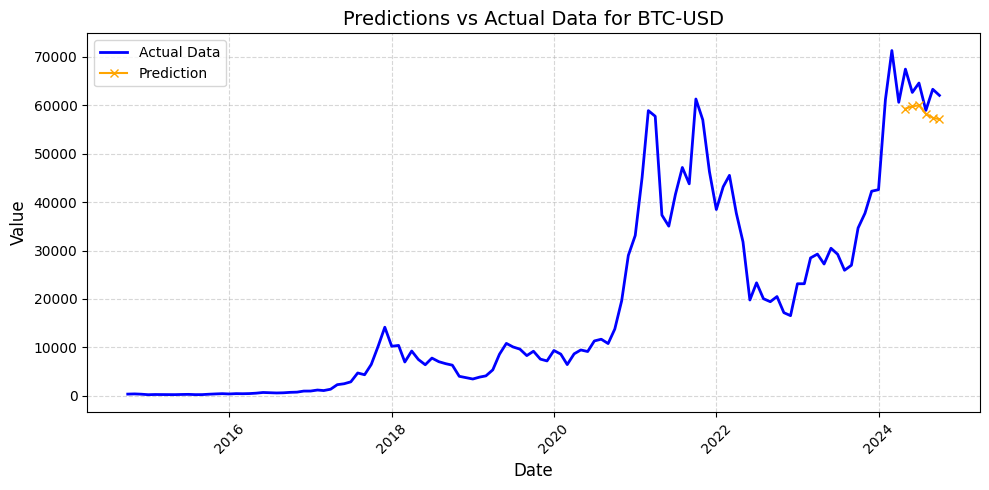

In [15]:
# Extract the actual and forecasted data
forecast_series = forecast[['ds', 'ARIMA']] 
real_series = Y_df[['ds', 'y']]  

plt.figure(figsize=(10, 5))

# Plot actual data as a solid line
plt.plot(real_series['ds'], real_series['y'], label='Actual Data', linestyle='-', color='blue', linewidth=2)

# Plot predictions as a dashed line
plt.plot(forecast_series['ds'], forecast_series['ARIMA'], label='Prediction', marker='x', color='orange')

# Configure the plot
plt.title(f'Predictions vs Actual Data for BTC-USD', fontsize=14)  
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(visible=True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()
